<a href="https://colab.research.google.com/github/a-apte/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/LS_DS_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

### Beijing Air Quality Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


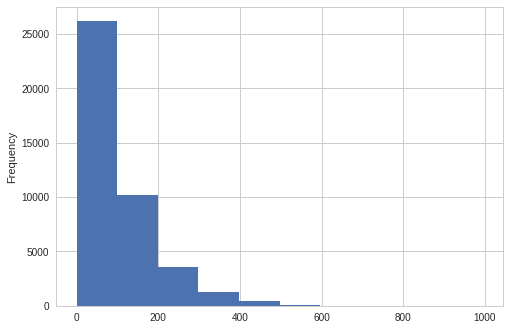

In [0]:
import matplotlib.style as style
style.use("seaborn-whitegrid")

df['pm2.5'].plot.hist();

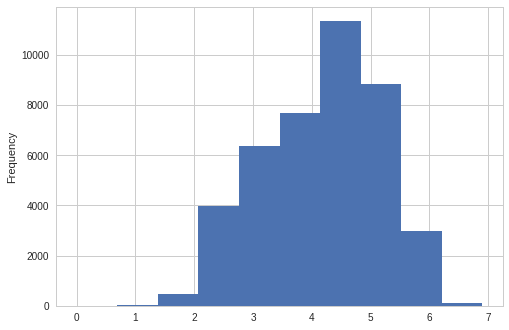

In [0]:
import numpy as np

pd.Series(np.log(1 + df['pm2.5'])).plot.hist()
                 
                 
# temp.plot.hist()

**LINEAR REGRESSION**

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

**QUANTILE REGRESSION**

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)
print("\n")

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
print(quant_reg.summary())  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        00:34:30   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print("\n",quantile*100,"th quantile\n")
  print(quant_mod.fit(q=quantile).summary())


 5.0 th quantile

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        00:34:32   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034 

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

(0.5, 0.1447879336023583)
(0.52, 0.1457984456251047)
(0.54, 0.1467640446791706)
(0.56, 0.14787821797693512)
(0.58, 0.14892138273908107)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.62, 0.15131550520931825)
(0.64, 0.152815632180745)
(0.66, 0.15440046026580068)
(0.68, 0.15607615678951559)
(0.7, 0.1577663389046554)
(0.72, 0.15961363441229715)
(0.74, 0.1617151201897239)
(0.76, 0.16394259393342125)
(0.78, 0.1664423443710097)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.82, 0.17195593122357777)
(0.84, 0.17599918426382777)
(0.86, 0.18047434708570964)
(0.88, 0.1850748927825704)
(0.9, 0.1899871464061209)
(0.92, 0.19409258046839573)
(0.94, 0.1990718585613529)
(0.96, 0.20828854295993626)


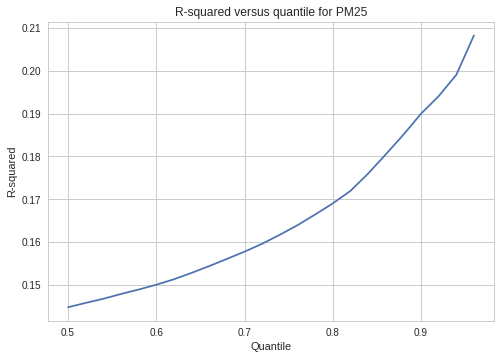

In [0]:
import matplotlib.pyplot as plt

quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
quantile_list = []
rsquared_list = []
for quantile in range(50, 98, 2):
  quantile /= 100
  quantile_list.append(quantile)
  quant_reg = quant_mod.fit(q=quantile)
  rsquared_list.append(quant_reg.prsquared)
  print((quantile, quant_reg.prsquared))
  
plt.plot(quantile_list, rsquared_list)
plt.xlabel("Quantile")
plt.ylabel("R-squared")
plt.title("R-squared versus quantile for PM25")

plt.show()

**q = 0.25**

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
print(quant_reg.summary())  # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        00:35:04   Df Residuals:                    41751
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2444      0.013    318.116      0.000       4.218       4.271
DEWP           0.0722      0.001     96.780      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.629      0.000      -0.072      -0.068
Ir            -0.1079      0.004    -29.400      0.0

**q = 0.5**

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
print(quant_reg.summary())  # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:               0.2156
Model:                       QuantReg   Bandwidth:                     0.02244
Method:                 Least Squares   Sparsity:                       0.3917
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        00:35:04   Df Residuals:                    41751
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7736      0.002    803.281      0.000       1.769       1.778
DEWP           0.0136      0.000    105.682      0.000       0.013       0.014
TEMP          -0.0135      0.000    -91.401      0.000      -0.014      -0.013
Ir            -0.0208      0.001    -30.343      0.0

**q = 0.75**

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.75)
print(quant_reg.summary())  # "summary" is another very R-thing

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:               0.1708
Model:                       QuantReg   Bandwidth:                    0.007724
Method:                 Least Squares   Sparsity:                       0.1441
Date:                Thu, 24 Jan 2019   No. Observations:                41757
Time:                        00:35:04   Df Residuals:                    41751
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0520      0.001   1452.781      0.000       1.051       1.053
DEWP           0.0040   4.15e-05     96.338      0.000       0.004       0.004
TEMP          -0.0042   5.01e-05    -83.623      0.000      -0.004      -0.004
Ir            -0.0059      0.000    -24.135      0.0

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

### IN-CLASS

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/''00272/SkillCraft1_Dataset.csv'

df = pd.read_csv(url)
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [0]:
print (df.shape)
df.dtypes

(3395, 20)


GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [0]:
# Not true as ? replace Nan values

df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [0]:
import numpy as np
df = df.replace('?', np.nan) # Replaced with Nan
df.isna().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [0]:
# Quinn's cleaning code
hasna = ['Age', 'HoursPerWeek', 'TotalHours']

for feat in hasna:
   df[feat] = pd.to_numeric(df[feat])
#df[hasna].head()

In [0]:
df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3340.000000,3339.000000,3338.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.647904,15.910752,960.421809,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.206341,11.962912,17318.133922,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [0]:
df.dtypes

GameID                    int64
LeagueIndex               int64
Age                     float64
HoursPerWeek            float64
TotalHours              float64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

**LINEAR REGRESSION**

In [0]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df['APM']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.9727919594327304

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

GameID 5.6721525875017124e-05
LeagueIndex -0.17025706089711906
Age -0.1255396800327562
HoursPerWeek -0.007084891488397346
TotalHours 6.181852927507429e-06
SelectByHotkeys 5530.168863103678
AssignToHotkeys -948.4647097091305
UniqueHotkeys 0.13583102775973996
MinimapAttacks 2972.11713661456
MinimapRightClicks 4053.6799567315898
NumberOfPACs 23408.13583534949
GapBetweenPACs -0.013256821980193232
ActionLatency -0.17291643312034718
ActionsInPAC 12.798743815559357
TotalMapExplored 0.01939336984054402
WorkersMade 2699.774992506199
UniqueUnitsMade -0.3208898754951155
ComplexUnitsMade 1538.092153791031
ComplexAbilitiesUsed -3127.832963745431


In [0]:
df.LeagueIndex.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

**QUANTILE REGRESSION**

In [0]:
# Let's say we want to answer "What are the fastest 10% of SC players like?"
# That means quantile regression with q=0.9

# First we need a formula, with our friend twiddle
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.9)

print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    APM   Pseudo R-squared:               0.4076
Model:                       QuantReg   Bandwidth:                       6.911
Method:                 Least Squares   Sparsity:                        179.3
Date:                Thu, 24 Jan 2019   No. Observations:                 3338
Time:                        00:35:07   Df Residuals:                     3318
                                        Df Model:                           19
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1786     22.328      0.008      0.994     -43.599      43.956
GameID                   0.0016      0.000      4.316      0.000       0.001       0.002
LeagueIndex             13.8712      1.115     12.443      0.000      11.685      16.057
Ag

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [0]:
quant_reg.predict(X)[:10]

0    177.075309
1    160.902179
2    112.099983
3    112.118587
4    175.772822
5     41.477271
6     66.971310
7    253.629747
8    122.742125
9    186.566630
dtype: float64

In [0]:
linear_reg.predict(X)[:10]

array([143.63118811, 130.48864924,  67.69761065, 101.45031334,
       130.15490286,  35.98091498,  41.51357034, 208.30622773,
       132.06158302, 144.13021461])

In [0]:
df.TotalHours.value_counts()

500.0        328
400.0        213
1000.0       210
300.0        202
600.0        187
800.0        186
700.0        170
200.0        168
730.0        123
100.0        116
450.0         97
250.0         85
150.0         73
900.0         71
750.0         70
350.0         66
1500.0        58
2000.0        55
650.0         47
1200.0        46
50.0          45
1260.0        28
120.0         26
550.0         23
850.0         22
1100.0        22
80.0          20
1400.0        18
60.0          18
30.0          17
            ... 
315.0          1
980.0          1
1000000.0      1
1466.0         1
711.0          1
425.0          1
153.0          1
477.0          1
9000.0         1
25000.0        1
2800.0         1
410.0          1
310.0          1
275.0          1
1870.0         1
865.0          1
18000.0        1
731.0          1
1098.0         1
770.0          1
460.0          1
3257.0         1
255.0          1
95.0           1
553.0          1
174.0          1
138.0          1
364.0         

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [0]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [0]:
print (bwt_df.shape)
bwt_df.dtypes

(1174, 7)


bwt          int64
gestation    int64
parity       int64
age          int64
height       int64
weight       int64
smoke        int64
dtype: object

In [0]:
bwt_df.isnull().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

In [0]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


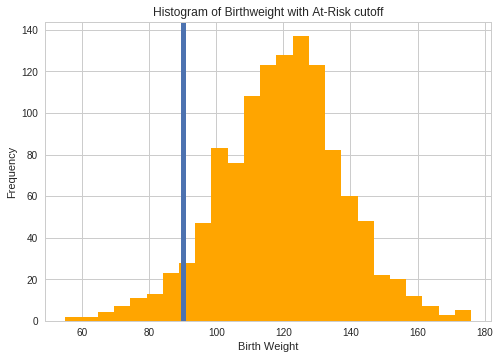

In [0]:
import matplotlib.pyplot as plt

plt.hist(bwt_df.bwt, bins=25, color='orange')

plt.axvline(x=90, linewidth = 5)

plt.xlabel('Birth Weight')
plt.ylabel('Frequency')

plt.title('Histogram of Birthweight with At-Risk cutoff')

plt.show()

# bwt_df.bwt.plot.hist(bins=25, color='orange')

**WHERE IS THE AT-RISK QUANTILE?**

In [0]:
from scipy import stats

stats.percentileofscore(bwt_df['bwt'], 90)

5.664395229982964

**CONFIRMATION**

In [0]:
bwt_df['bwt'].quantile(0.0566)

90.0

**LINEAR REGRESSION**

**The entire dataset**

In [0]:
bwt_df.columns

Index(['bwt', 'gestation', 'parity', 'age', 'height', 'weight', 'smoke'], dtype='object')

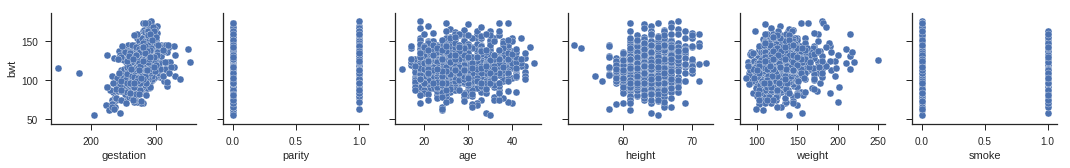

In [0]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

x_cols = ['gestation', 'parity', 'age', 'height', 'weight', 'smoke']


# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data = bwt_df, y_vars= 'bwt', x_vars=x_cols)

In [0]:
# TODO - your work here! Also, add text cells for written questions.

# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2579534937842991

**The large dataset Linear Regression model is not terribly good at predicting birth weight.**

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.4439783392634531
parity -3.327199613351645
age -0.008950305361154154
height 1.1540203642500357
weight 0.05016502707680326
smoke -8.40073348432133


**The at-risk subset**

In [0]:
atrisk = bwt_df[bwt_df.bwt <=90]

print (atrisk.shape)
atrisk.describe()

(68, 7)


,bwt,gestation,parity,age,height,weight,smoke
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,80.058824,258.235294,0.235294,27.985294,63.676471,127.352941,0.617647
std,8.409097,18.505439,0.427336,6.040887,2.390536,23.239033,0.489575
min,55.000000,204.000000,0.000000,18.000000,58.000000,95.000000,0.000000
25%,75.000000,244.250000,0.000000,23.000000,62.000000,109.500000,0.000000
50%,83.500000,261.000000,0.000000,27.000000,64.000000,124.500000,1.000000
75%,87.000000,274.000000,0.000000,32.000000,65.250000,141.000000,1.000000
max,90.000000,290.000000,1.000000,41.000000,69.000000,200.000000,1.000000


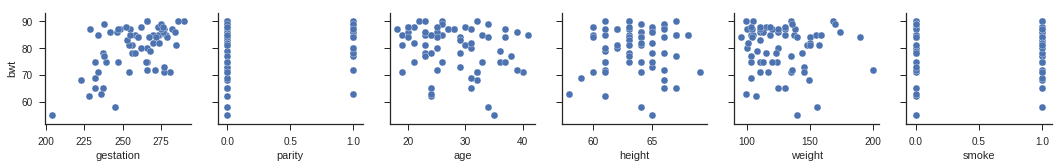

In [0]:
sns.set(style="ticks", color_codes=True)

x_cols = ['gestation', 'parity', 'age', 'height', 'weight', 'smoke']


# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data = atrisk, y_vars= 'bwt', x_vars=x_cols)

In [0]:
X2 = atrisk.drop('bwt', axis='columns')
y2 = atrisk['bwt']

linear_reg = LinearRegression().fit(X2, y2)
linear_reg.score(X2, y2)

0.366216795666226

**This model is more accurate than that of the larger set.**

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

gestation 0.25313007819890787
parity 0.9401409332986111
age -0.2750623848238271
height 0.656218068776905
weight -0.06392780885162608
smoke -0.8731601137913951


**Interesting to see the dramatic shift in coefficients as one looks at only the at-risk subset. Parity went from highly negative to positive. Smoking saw the largest change.**

**QUANTILE REGRESSION**

In [0]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)


quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566) # Determined earlier

print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.229
Method:                 Least Squares   Sparsity:                        132.4
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        00:35:10   Df Residuals:                     1167
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.272     -32.392
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1.337
age           -0.0836      0.172     -0.486      0.6

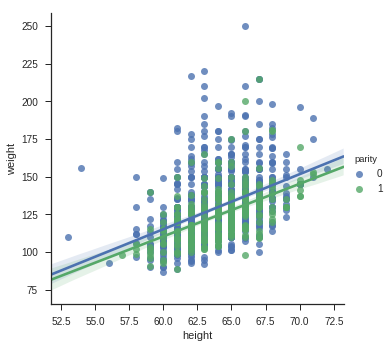

In [0]:
sns.lmplot(x="height", y="weight", hue = 'parity', data=bwt_df)

**IMPROVING THE MODEL - FEATURE ENGINEERING**

In [0]:
bwt_df.corr()

,bwt,gestation,parity,age,height,weight,smoke
bwt,1.000000,0.407543,-0.043908,0.026983,0.203704,0.155923,-0.246800
gestation,0.407543,1.000000,0.080916,-0.053425,0.070470,0.023655,-0.060267
parity,-0.043908,0.080916,1.000000,-0.351041,0.043543,-0.096362,-0.009599
age,0.026983,-0.053425,-0.351041,1.000000,-0.006453,0.147322,-0.067772
height,0.203704,0.070470,0.043543,-0.006453,1.000000,0.435287,0.017507
weight,0.155923,0.023655,-0.096362,0.147322,0.435287,1.000000,-0.060281
smoke,-0.246800,-0.060267,-0.009599,-0.067772,0.017507,-0.060281,1.000000


In [0]:
bwt_df['height_weight'] = bwt_df['height'] * bwt_df['weight']
bwt_df['weight_div_height'] = bwt_df['weight'] / bwt_df['height'] 
bwt_df['age_parity'] = bwt_df['age'] * bwt_df['parity']

bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,height_weight,weight_div_height,age_parity
0,120,284,0,27,62,100,0,6200,1.612903,0
1,113,282,0,33,64,135,0,8640,2.109375,0
2,128,279,0,28,64,115,1,7360,1.796875,0
3,108,282,0,23,67,125,1,8375,1.865672,0
4,136,286,0,25,62,93,0,5766,1.500000,0


In [0]:
bwt_df['log_age'] = np.log(bwt_df['age'])
bwt_df['log_weight'] = np.log(bwt_df['weight'])

bwt_df['height_log_weight'] = bwt_df['log_weight'] * bwt_df['height']
bwt_df['log_weight_div_height'] = bwt_df['log_weight'] / bwt_df['height']
bwt_df['log_age_parity'] = bwt_df['log_age'] * bwt_df['parity']

bwt_df.head()


,bwt,gestation,parity,age,height,weight,smoke,height_weight,weight_div_height,age_parity,log_age,log_weight,height_log_weight,log_weight_div_height,log_age_parity
0,120,284,0,27,62,100,0,6200,1.612903,0,3.295837,4.605170,285.520552,0.074277,0.0
1,113,282,0,33,64,135,0,8640,2.109375,0,3.496508,4.905275,313.937586,0.076645,0.0
2,128,279,0,28,64,115,1,7360,1.796875,0,3.332205,4.744932,303.675656,0.074140,0.0
3,108,282,0,23,67,125,1,8375,1.865672,0,3.135494,4.828314,323.497020,0.072064,0.0
4,136,286,0,25,62,93,0,5766,1.500000,0,3.218876,4.532599,281.021169,0.073106,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


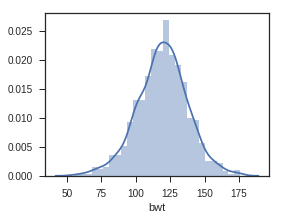

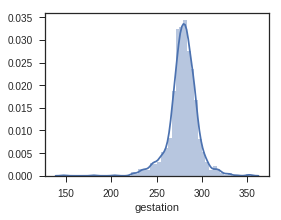

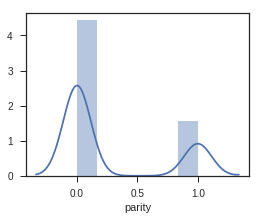

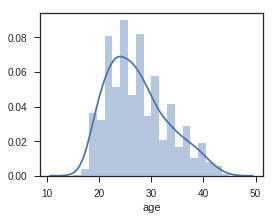

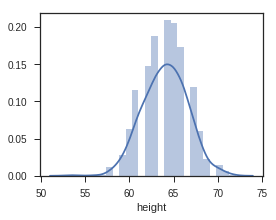

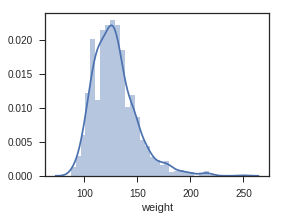

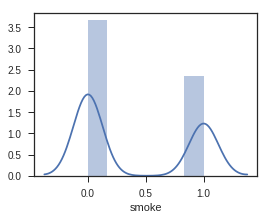

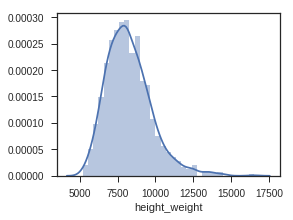

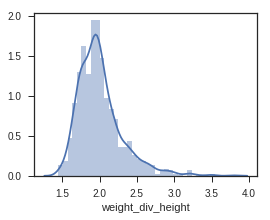

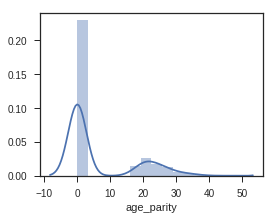

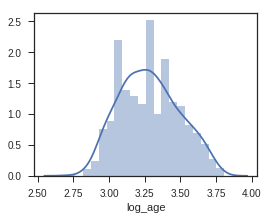

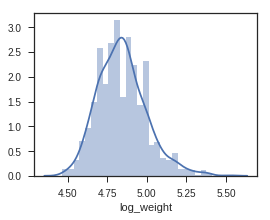

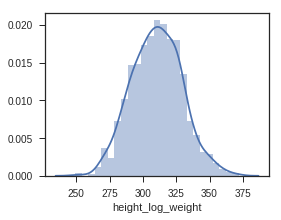

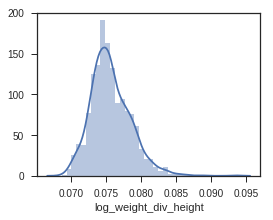

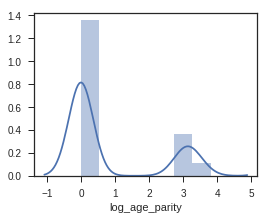

In [0]:
for col in bwt_df.columns:  
  fig = plt.figure()
  ax1 = fig.add_subplot(111)
  fig.set_size_inches(4, 3)
  sns.distplot(bwt_df[col])  
  plt.show()

In [0]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)


quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.0566) # Determined earlier

print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.2083
Model:                       QuantReg   Bandwidth:                       6.255
Method:                 Least Squares   Sparsity:                        116.4
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        00:36:07   Df Residuals:                     1159
                                        Df Model:                           14
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.4699   3846.575      0.000      1.000   -7545.560    7548.500
gestation                 0.5024      0.080      6.265      0.000       0.345       0.660
parity                    1.1912    183.750      0.006      0.995    -359.328     361.7

In [0]:
bwt_df.columns

Index(['bwt', 'gestation', 'parity', 'age', 'height', 'weight', 'smoke',
       'height_weight', 'weight_div_height', 'age_parity', 'log_age',
       'log_weight', 'height_log_weight', 'log_weight_div_height',
       'log_age_parity'],
      dtype='object')

**SECOND PASS - Eliminating variables with high p values**

**Feature Engineering resulted in more features being dropped. As a result, one returns to the previous model with height and weight both being statistically significant.**

In [0]:
bwt_df2 = bwt_df[['bwt', 'gestation', 'smoke', 'height', 'weight']] #, 'height_weight']]

In [0]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df2.drop('bwt', axis='columns').columns)


quant_mod = smf.quantreg(quant_formula, data=bwt_df2)
quant_reg = quant_mod.fit(q=.0566) # Determined earlier

print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1964
Model:                       QuantReg   Bandwidth:                       6.254
Method:                 Least Squares   Sparsity:                        126.9
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        00:36:16   Df Residuals:                     1169
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -102.4171     30.676     -3.339      0.001    -162.603     -42.231
gestation      0.4679      0.088      5.346      0.000       0.296       0.640
smoke         -9.6929      1.772     -5.471      0.000     -13.169      -6.217
height         1.3356      0.409      3.265      0.0

**QUANTILE REGRESSION VISUALIZATION**

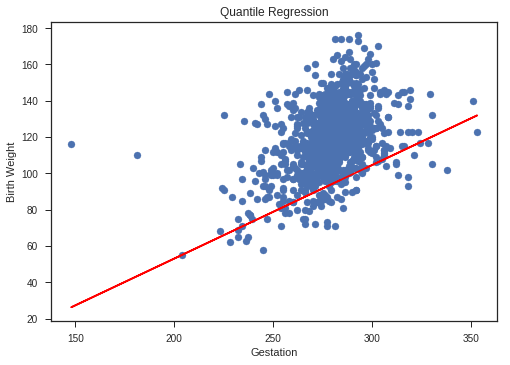

In [0]:
bwt_df_viz = bwt_df[['bwt', 'gestation']]

quant_formula_viz = 'bwt ~ ' + ' + '.join(bwt_df_viz.drop('bwt', axis='columns').columns)

quant_mod = smf.quantreg(quant_formula_viz, data=bwt_df_viz)
quant_reg = quant_mod.fit(q=.0566) # Determined earlier

# print(quant_reg.summary())

X = bwt_df_viz['gestation']
y = bwt_df_viz['bwt']
# y_pred = quant_reg.predict(X)

plt.scatter(X,y)
plt.plot(X,y_pred, color = 'red')
plt.xlabel('Gestation')
plt.ylabel('Birth Weight')
plt.title('Quantile Regression Line q = 0.0566')

plt.show()

          NEW FEATURES
          bwt: baby's weight in ounces at birth
          gestation: duration of pregnancy in days
          parity: parity indicator (first born = 1, later birth = 0)
          age: mother's age in years
          height: mother's height in inches
          weight: mother's weight in pounds (during pregnancy)
          smoke: indicator for whether mother smokes (1=yes, 0=no) 
          height_weight : measure of body mass
          age_parity: indication of how old mother was for first child
          log_age: log transform of age
          log_weight: log transform of weight
          height_log_weight: height * log(weight) (body mass)
          log_age_parity: same as age-parity but with log age
          weight_div_height: weight divided by height
          log_weight_div_height: log(weight) divided by height

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?

**The charateristics that indicate the highest likelihood of an at-risk birth are smoking (if the mother smokes, she is more likely to deliver a lower weight baby), gestation (the longer the pregnancy, the higher the birth weight), the mother's height (the taller the mother, the higher the birth weight) and the mother's weight (the higher the mother's weight, the lower the birth weight).**


- What can expectant mothers be told to help mitigate this risk?

**In terms of factors that are within the control of the mother, the mother should definitely quit smoking while pregnant and possibly adopt a healthier lifestyle (assuming that mother's weight is the proxy for this) which includes a healthy diet and exercise.**

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model